In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cmcrameri import cm as  cmc
import matplotlib as mpl
import pandas as pd
import xarray as xr
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_plots as mp
import model1_explore as me
import model1 as mod1
from scipy.stats import norm, beta
from statsmodels.base.model import GenericLikelihoodModel
import palettable as pal

import Utilities as util


In [90]:
loc_model = '../mod/model1/'
loc_fig = '../fig/model1/'

# read data
# explorative
# 0. overview
ds_c = xr.open_dataset(loc_model + 'expl_hist_clouds.nc')
T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)



# 1. cs -> cs

# 2. c -> cs
ds_local = xr.open_dataset(loc_model + 'expl_local_param.nc')

# 3. cs -> c
ds_cs_c = xr.open_dataset(loc_model + 'expl_hist_cs_to_c.nc')

# 4. c -> c
df = pd.read_csv(loc_model + 'expl_example_bin_data.csv')
df_bin_fit = pd.read_csv(loc_model + 'expl_examble_bin_fit.csv')
# ds_local local param 

# global model1
# df_glob_c_to_c_cod = pd.read_csv(loc_model + 'glob_c_to_c_cod.csv')
ds_theta = xr.open_dataset(loc_model + 'glob_theta.nc')




In [91]:
T_total

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
from,,,,,,,,,,,
0.0,0.211914,0.111387,0.087186,0.055693,0.217965,0.051970,0.036146,0.133881,0.008998,0.017996,0.066863
1.0,0.001191,0.748846,0.119407,0.016537,0.059605,0.036653,0.002945,0.013687,0.000825,0.000100,0.000205
2.0,0.002656,0.176882,0.522721,0.060487,0.058385,0.148999,0.014564,0.010262,0.004083,0.000601,0.000361
3.0,0.002473,0.060011,0.133837,0.386327,0.193412,0.031283,0.146011,0.038981,0.001090,0.005341,0.001233
4.0,0.003226,0.072735,0.042969,0.061524,0.678427,0.008358,0.013143,0.116818,0.000271,0.000437,0.002092
5.0,0.001607,0.107668,0.304109,0.026847,0.022895,0.438904,0.045888,0.022435,0.024449,0.004011,0.001188
6.0,0.001043,0.009189,0.030944,0.130582,0.037556,0.050856,0.572714,0.093322,0.003696,0.060473,0.009623
7.0,0.002001,0.022322,0.010831,0.016543,0.156770,0.012157,0.043974,0.661905,0.000733,0.004877,0.067888
8.0,0.002767,0.028794,0.116405,0.013526,0.010042,0.468696,0.062301,0.023261,0.219592,0.047443,0.007173


## 0. Cloud distribution

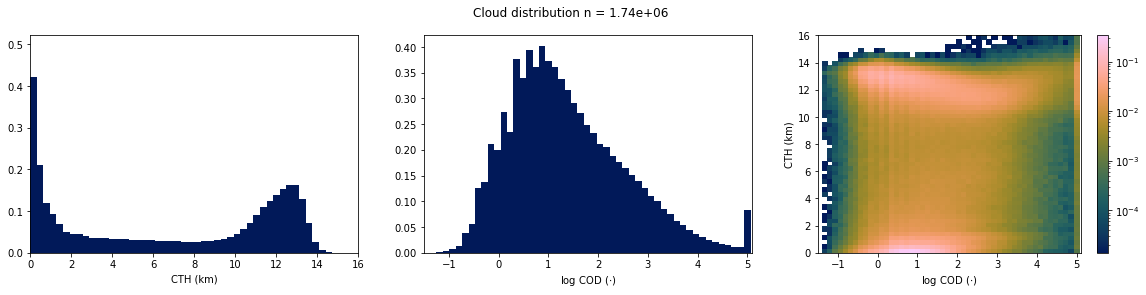

In [92]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=2, n=16)

dedges, hedges, freq = ds_c.dedges.data, ds_c.hedges.data, ds_c.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
fig.savefig(loc_fig + 'expl_cloud_distr.png')

# .colorbrewer.sequential import Blues_8
# ax.imshow(data, cmap=Blues_8.mpl_colormap)


In [93]:
T = T_total#.iloc[:-1]
print(T.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T = T.rename(
            columns = classes, 
             index = classes
            )
T

import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)

T.style.background_gradient(cmap=plt.cm.Blues)
# classes

Index(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', 'All'],
      dtype='object', name='from')


,invalid pixel,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,,
invalid pixel,0.211914,0.111387,0.087186,0.055693,0.217965,0.051970,0.036146,0.133881,0.008998,0.017996,0.066863
clear sky,0.001191,0.748846,0.119407,0.016537,0.059605,0.036653,0.002945,0.013687,0.000825,0.000100,0.000205
cumulus,0.002656,0.176882,0.522721,0.060487,0.058385,0.148999,0.014564,0.010262,0.004083,0.000601,0.000361
altocumulus,0.002473,0.060011,0.133837,0.386327,0.193412,0.031283,0.146011,0.038981,0.001090,0.005341,0.001233
cirrus,0.003226,0.072735,0.042969,0.061524,0.678427,0.008358,0.013143,0.116818,0.000271,0.000437,0.002092
stratocumulus,0.001607,0.107668,0.304109,0.026847,0.022895,0.438904,0.045888,0.022435,0.024449,0.004011,0.001188
altostratus,0.001043,0.009189,0.030944,0.130582,0.037556,0.050856,0.572714,0.093322,0.003696,0.060473,0.009623
cirrostratus,0.002001,0.022322,0.010831,0.016543,0.156770,0.012157,0.043974,0.661905,0.000733,0.004877,0.067888
stratus,0.002767,0.028794,0.116405,0.013526,0.010042,0.468696,0.062301,0.023261,0.219592,0.047443,0.007173


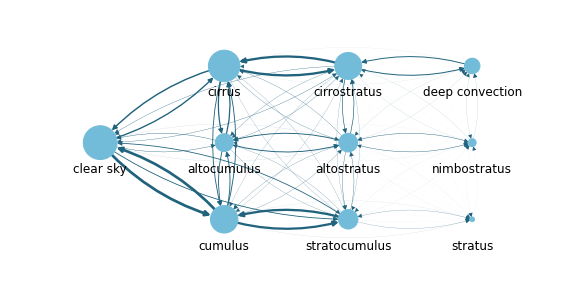

In [98]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}

node_size = T.loc['All', node_names] * 5000
edge_widths = [w * T.loc['All',edge[0]] * 100 for (*edge, w) in G.edges.data('weight')] # weight * node size
labels = {item:item for item in node_names}

fig = plt.figure(figsize = (10, 5))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size = node_size,
        node_color =  '#72BCD9',
#         alpha = 0,
)

nx.draw_networkx_edges(G, pos, width=edge_widths,
                       node_size = node_size,
                       edge_color = '#21637D',
                       connectionstyle='arc3, rad=.15'
 )

pos_labels = {k: v + [0, -.35] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels, font_color = 'black')
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)

plt.savefig(loc_fig + 'graph.png', transparent=True)

In [78]:
# edge_widths = [(w * 10 , print(T.loc['All',edge[0]])) for (*edge, w) in G.edges.data('weight')]


# 1. Clear sky to Clear sky

In [56]:
# no exploration needed
ds_local.p_cscs

0.7308294268298162

# 2. Cloud to clear sky

In [62]:
dh = ds_local.dh
dd = ds_local.dd
mu_h = ds_local.mu_h # m
mu_d = ds_local.mu_d
n_h = len(mu_h)
n_d = len(mu_d)

ds_local

<xarray.Dataset>
Dimensions:  (mu_d: 19, mu_h: 53)
Coordinates:
  * mu_h     (mu_h) float64 150.0 450.0 750.0 ... 1.515e+04 1.545e+04 1.575e+04
  * mu_d     (mu_d) float64 -1.0 -0.7 -0.4 -0.1 0.2 0.5 ... 3.2 3.5 3.8 4.1 4.4
Data variables: (12/14)
    p_cs     (mu_h, mu_d) float64 ...
    n_c      (mu_h, mu_d) float64 ...
    mu       (mu_h, mu_d) float64 ...
    sigma    (mu_h, mu_d) float64 ...
    n_cc     (mu_h, mu_d) float64 ...
    alpha    (mu_h, mu_d) float64 ...
    ...       ...
    beta1    (mu_h, mu_d) float64 ...
    alpha2   (mu_h, mu_d) float64 ...
    beta2    (mu_h, mu_d) float64 ...
    p        (mu_h, mu_d) float64 0.631 0.6408 0.5633 0.6672 ... nan nan 1.0 nan
    conv_b   (mu_h, mu_d) float64 ...
    conv_mb  (mu_h, mu_d) float64 ...
Attributes:
    dh:       300
    dd:       0.3
    p_cscs:   0.7308294268298162

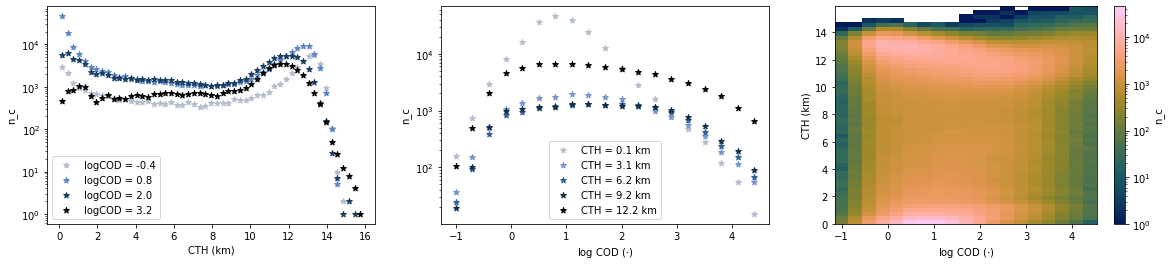

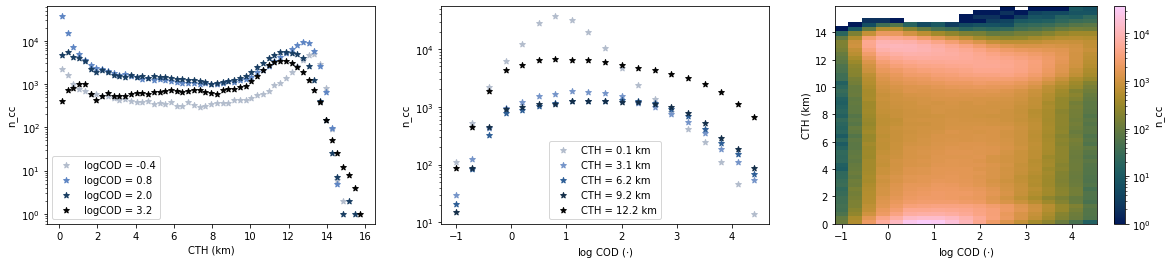

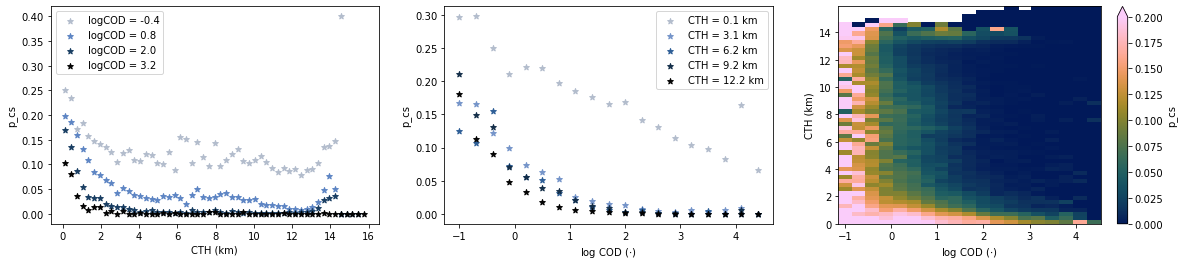

In [63]:
fig, ax = mp.plotLocalParam(ds_local.n_c, logscale = True)
fig.savefig(loc_fig + 'expl_local_n_c.png')

fig, ax = mp.plotLocalParam(ds_local.n_cc, logscale = True)
fig.savefig(loc_fig + 'expl_local_n_cc.png')

fig, ax = mp.plotLocalParam(ds_local.p_cs, logscale = False, vmax = .2)
fig.savefig(loc_fig + 'expl_local_p_cs.png')

# 3. Clear sky to Cloud

<xarray.DataArray 'theta3' (cs_to_c: 11)>
array([ 0.354359,  1.815221,  0.813067, 25.047808,  1.825146,  1.435239,
        0.798619,  0.749848,  0.73024 ,  1.      ,  1.      ])
Dimensions without coordinates: cs_to_c
Attributes:
    var_names:  ['alpha', 'beta', 'alpha1', 'beta1', 'alpha2', 'beta2', 'p', ...

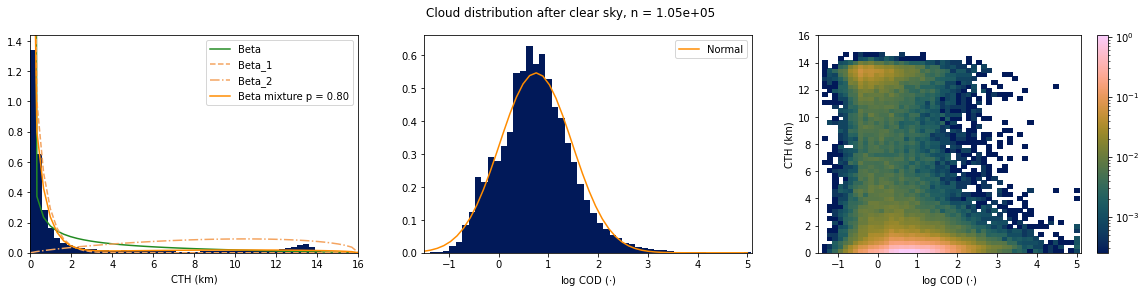

In [82]:
freq = ds_cs_c.freq.data

fig, ax = mp.plotCloudHist_f(ds_cs_c.dedges.data, ds_cs_c.hedges.data, ds_cs_c.freq.data,
                          title = f'Cloud distribution after clear sky, n = {ds_cs_c.freq.data.sum().sum():.2e}',
                         density = True)
theta = ds_theta.theta3
mp.plotCTHBeta(ax[0], *theta[0:2])
mp.plotCTHBetaMix(ax[0], *theta[2:7].data)
mp.plotCODNormal(ax[1], *theta[7:9])

fig.savefig(loc_fig + 'expl_cs_cloud_distr_3.png')
theta



# 4. Cloud to Cloud

1000.0 0.0
6000.0 0.0
9000.0 0.0
12000.0 0.0
1000.0 1.0
6000.0 1.0
9000.0 1.0
12000.0 1.0
1000.0 2.0
6000.0 2.0
9000.0 2.0
12000.0 2.0
1000.0 3.0
6000.0 3.0
9000.0 3.0
12000.0 3.0


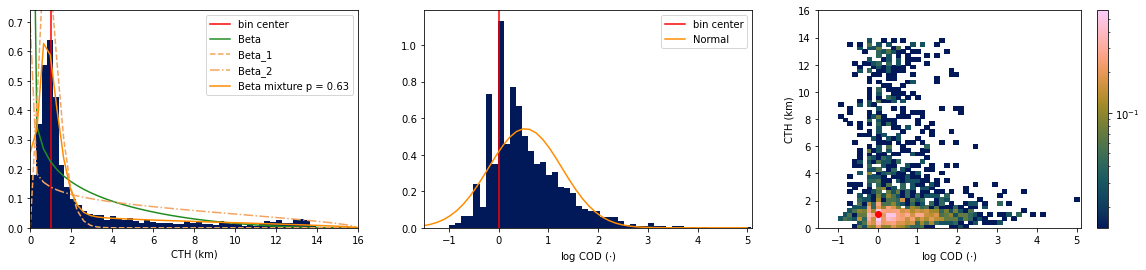

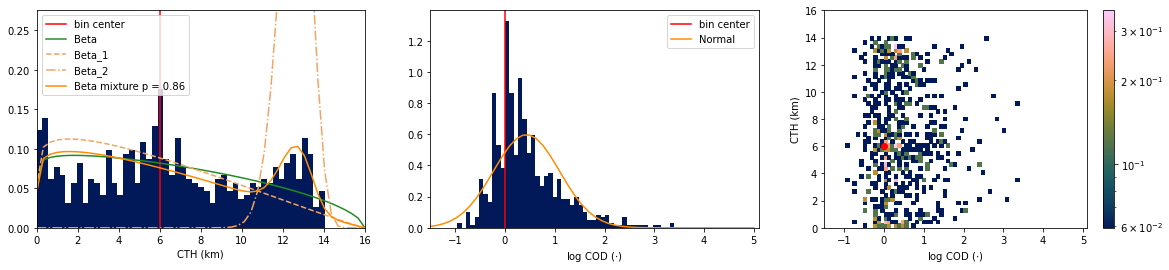

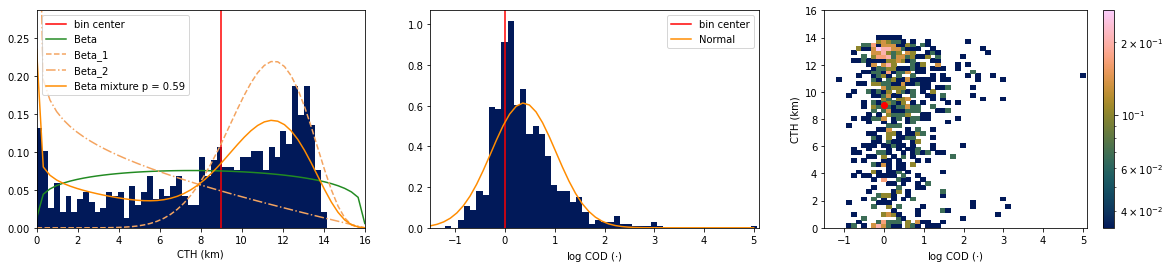

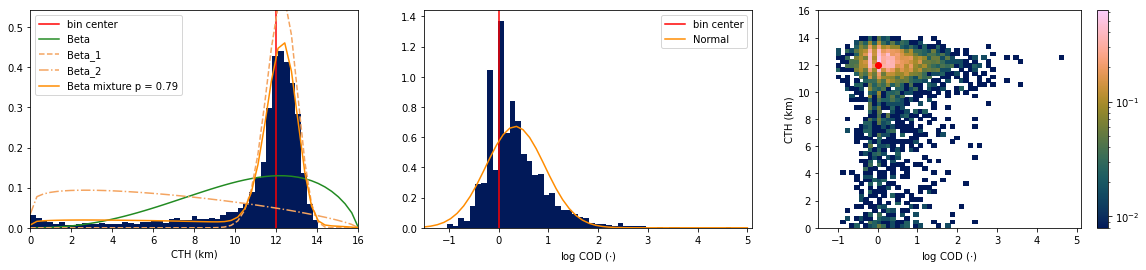

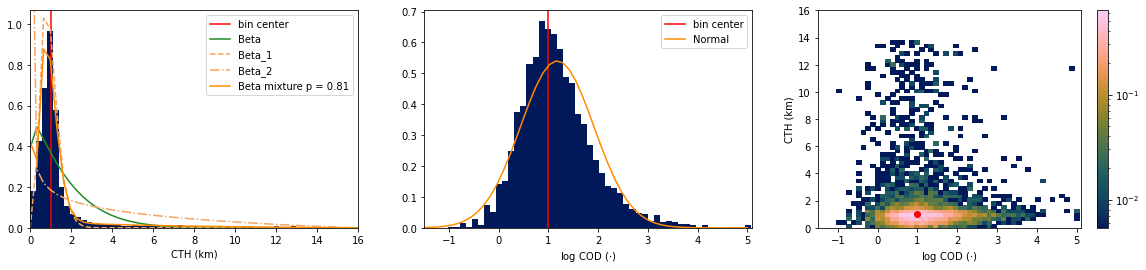

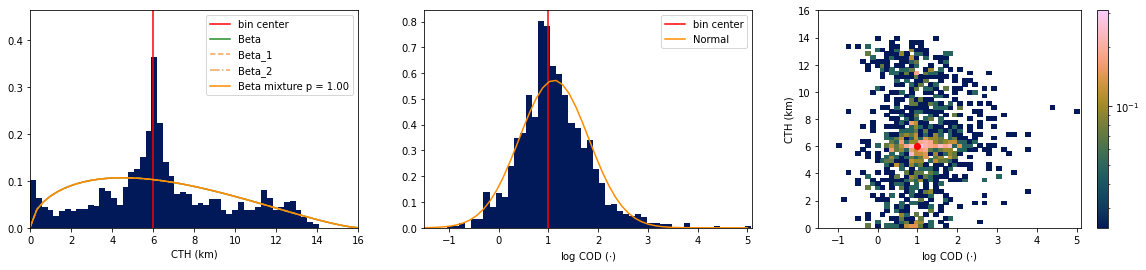

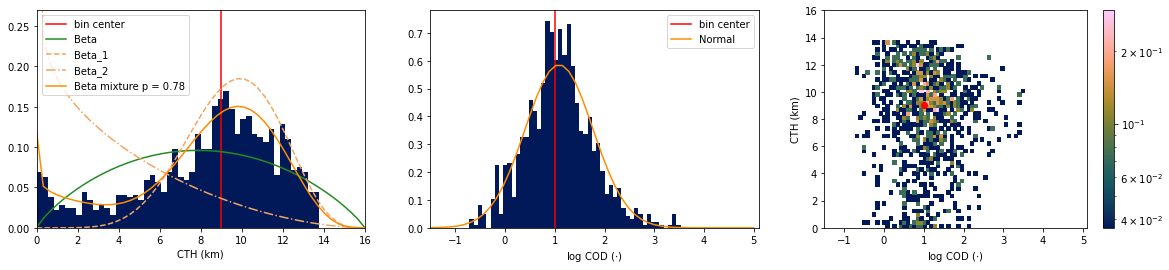

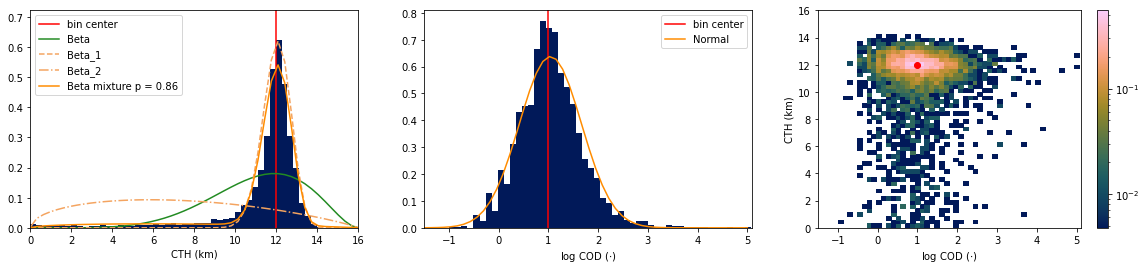

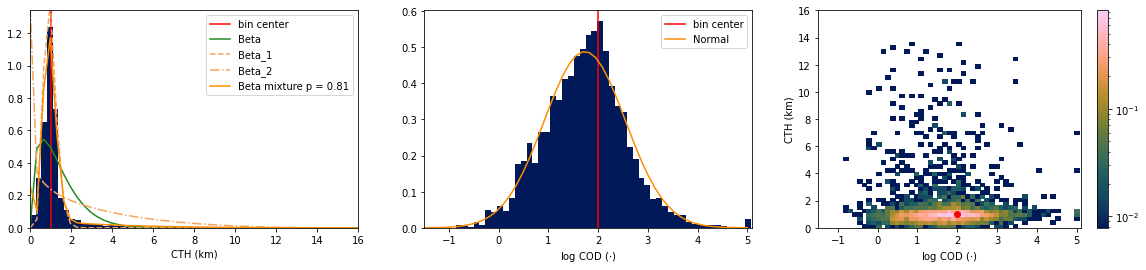

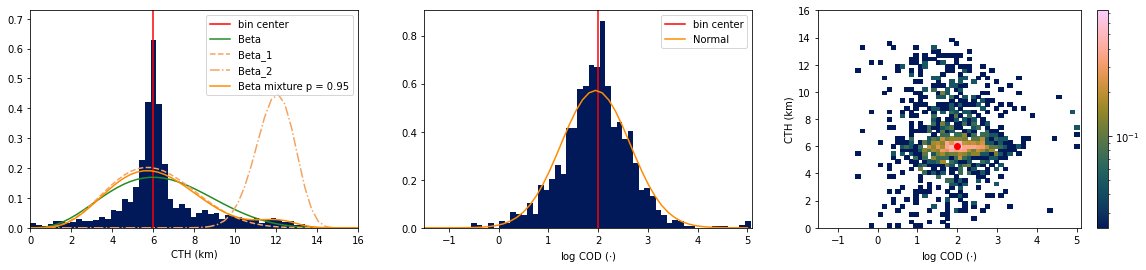

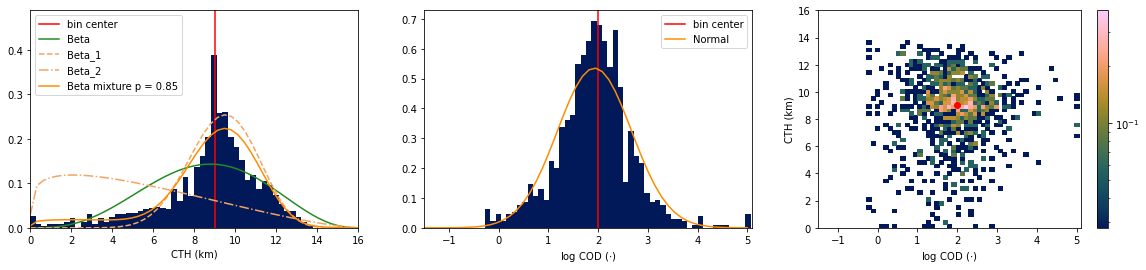

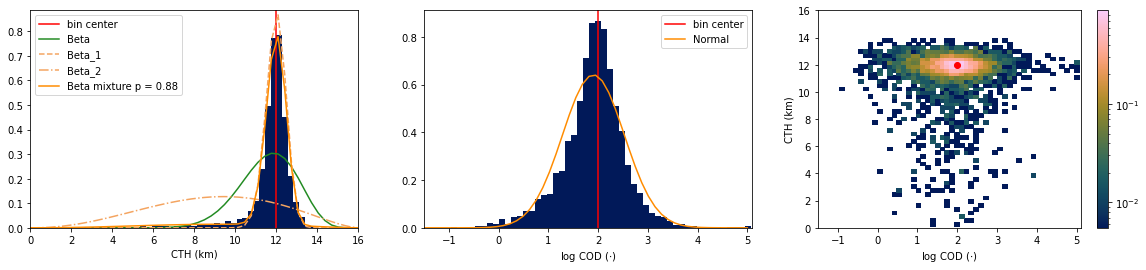

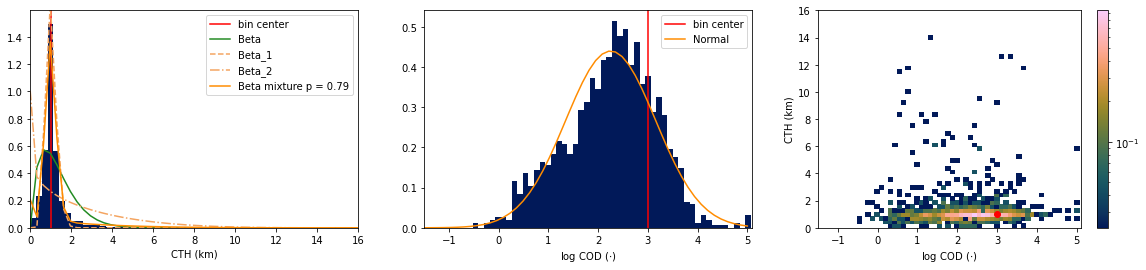

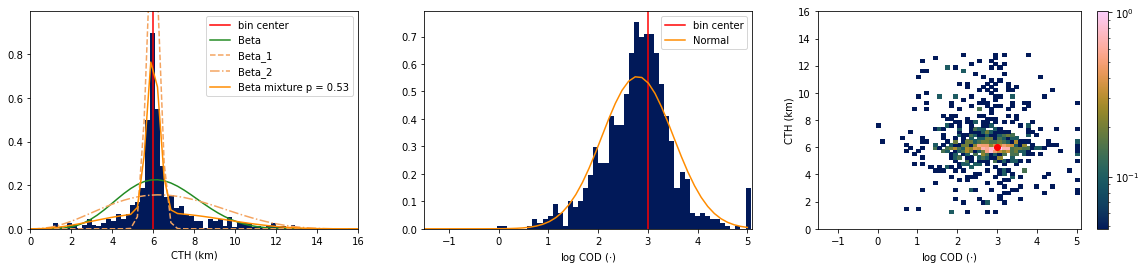

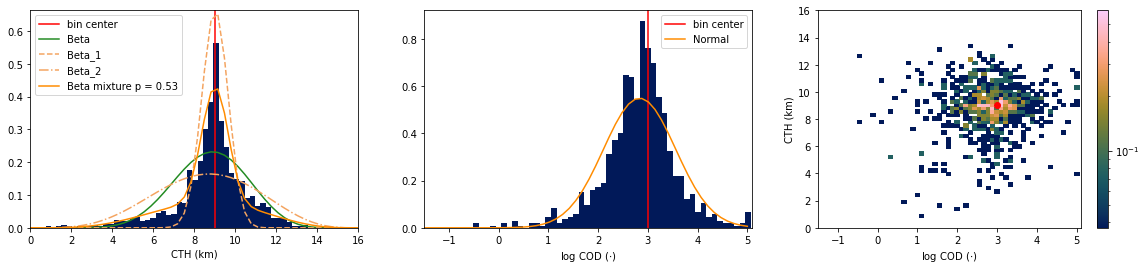

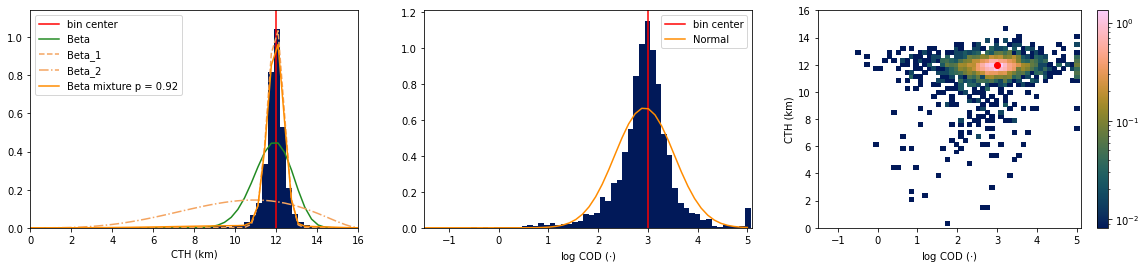

In [67]:
hlim = mp.hlim
dlim = mp.dlim

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
    print(h,d)
    
    fig , ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint

    # bin centers
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')

    # fits
    # cod
    D = np.linspace(-1.5, 5, 50)
    H = np.linspace(0, 15e3, 50)
    H_norm = ml.CTHtoUnitInt(H)

    h_beta_fit = beta(param.alpha, param.beta).pdf(H_norm)
    p = param.p.values[0] 
    
    mp.plotCTHBeta(ax[0], param.alpha, param.beta)
    mp.plotCTHBetaMix(ax[0], param.alpha1, param.beta1, param.alpha2, param.beta2, param.p.values[0])
    mp.plotCODNormal(ax[1], param.mu, param.sigma)
    
    fig.savefig(loc_fig + f'expl_bins{idx}.png')


## local behaviour parameters

## cod

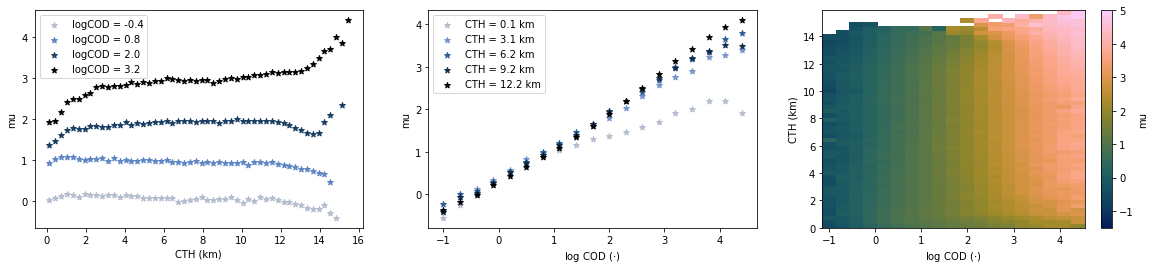

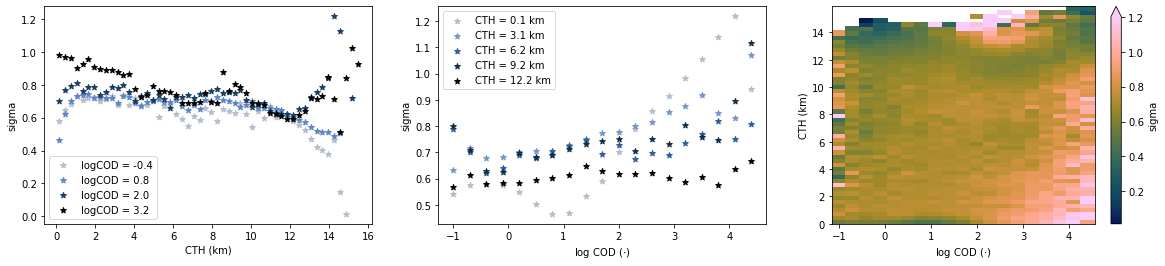

In [76]:

fig, ax = mp.plotLocalParam(ds_local.mu, vmin = -1.5, vmax = 5)
fig.savefig('../fig/model1/expl_local_mu.png')

fig, ax = mp.plotLocalParam(ds_local.sigma, vmax = 1.2)
fig.savefig('../fig/model1/expl_local_sigma.png')

## CTH

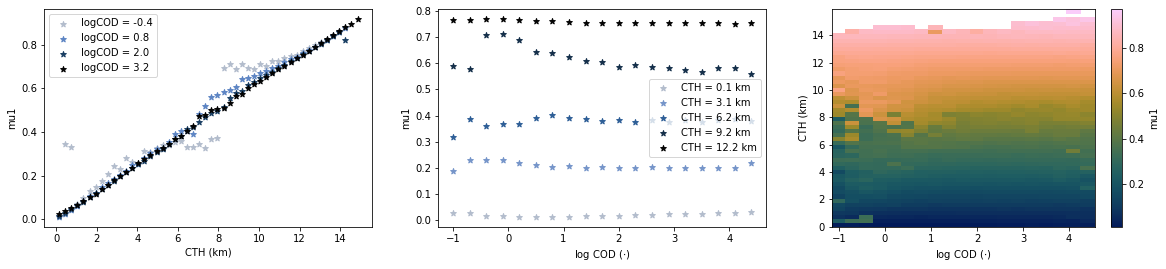

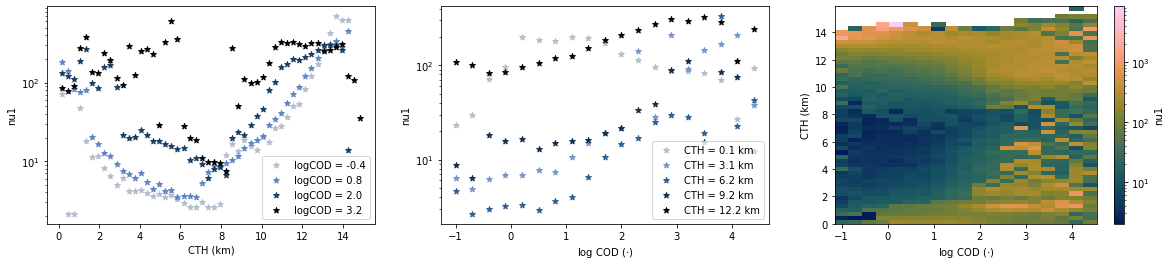

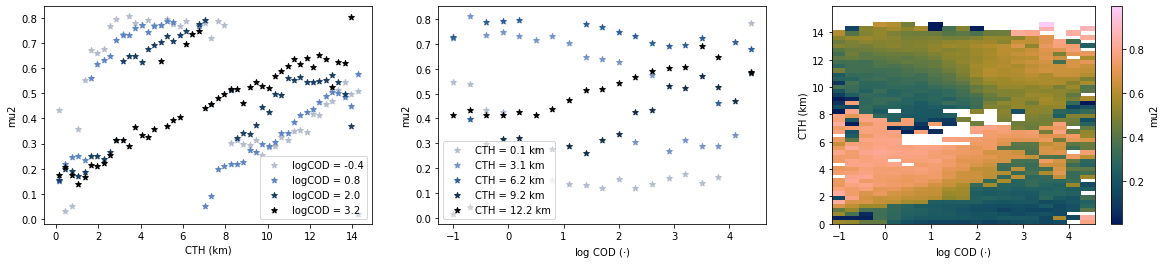

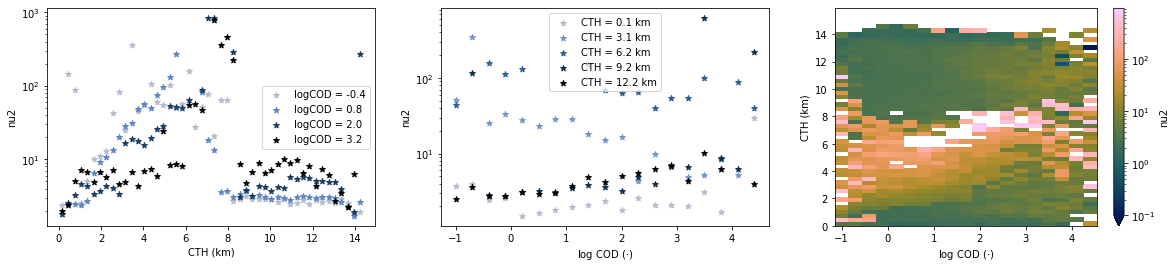

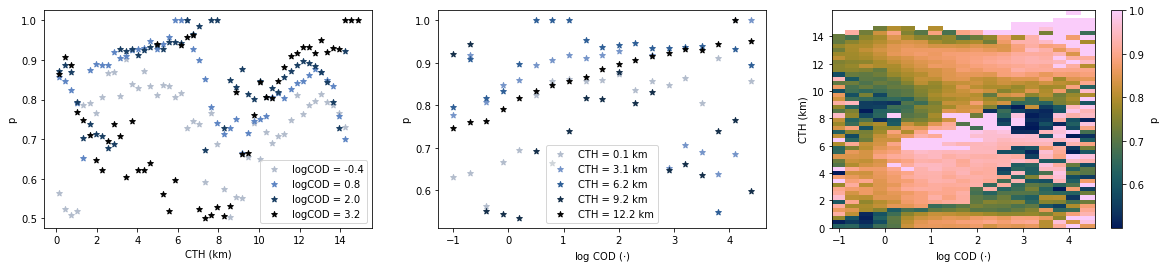

In [77]:
mu1 = me.meanBeta(ds_local.alpha1, ds_local.beta1).rename('mu1')
nu1 = (ds_local.alpha1 + ds_local.beta1).rename('nu1')
mu2 = me.meanBeta(ds_local.alpha2, ds_local.beta2).rename('mu2')
nu2 = (ds_local.alpha2 + ds_local.beta2).rename('nu2')

fig, ax = mp.plotLocalParam(mu1)
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(nu1, logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(mu2)
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(nu2, logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p)
fig.savefig(loc_fig + 'expl_local_p.png')


Text(0.5, 0.98, 'Estimators of time distribution COD')

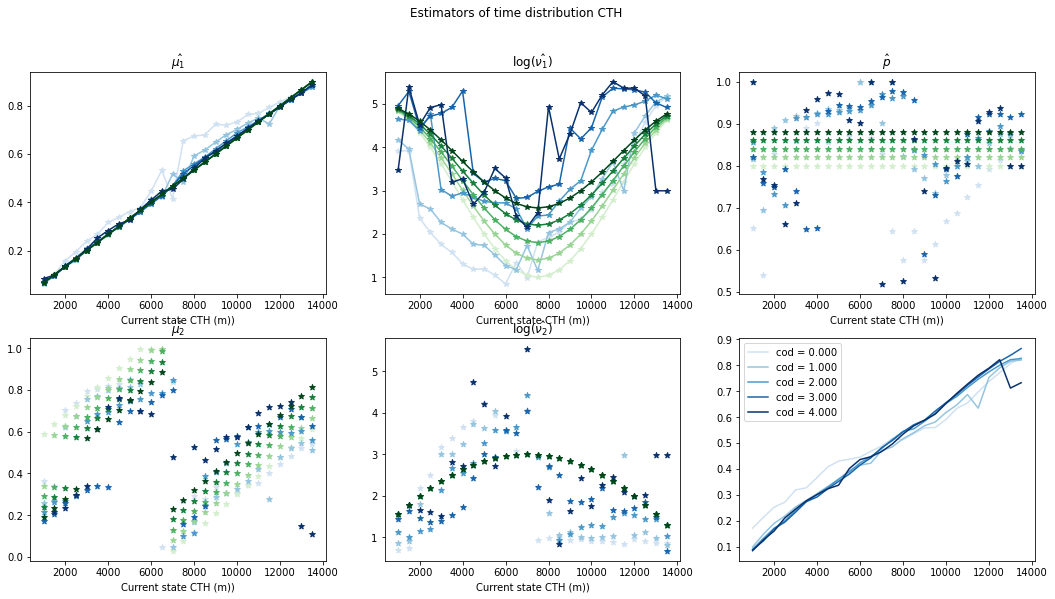

C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


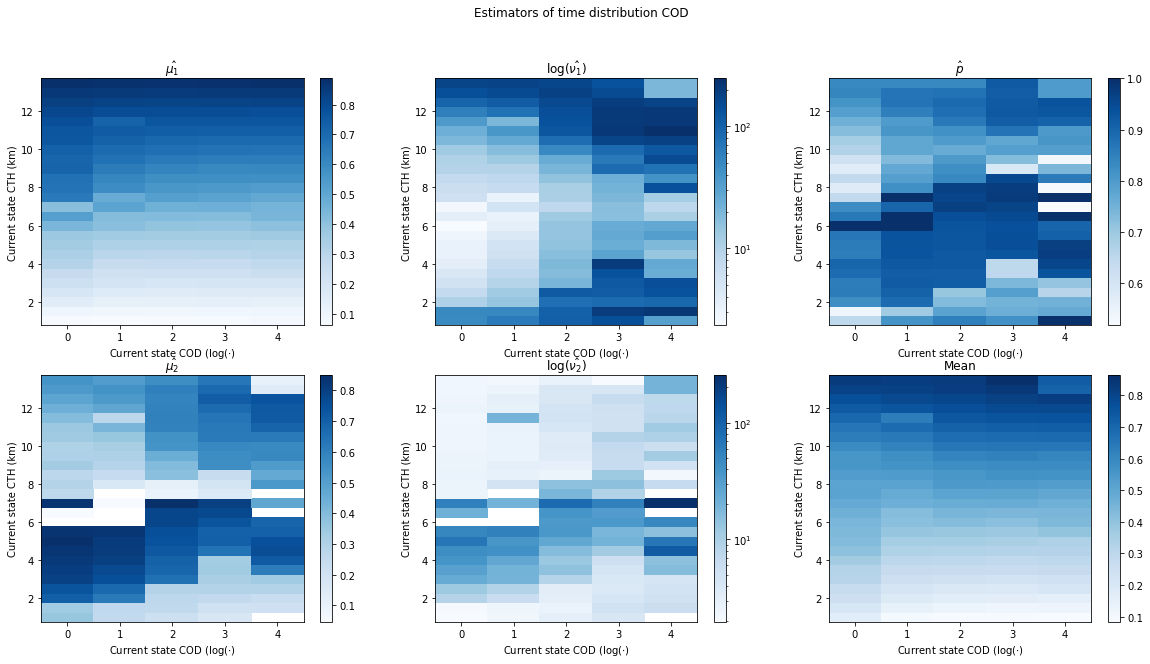

## clear sky to cloud

## cloud to clear sky